Скачайте архив с наборами данных для задачи классификации или изучите API сайта OpenML.

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
folder_name = 'OpenML/'
datasets_folder = 'data/'
information_file_name = 'data.csv'

In [3]:
to_file = 'Normal/'

In [4]:
import pandas as pd

In [5]:
information = pd.read_csv(folder_name + information_file_name)

In [6]:
information.head()

,id,name,length,target
0,10,lymph,22513,class
1,1000,hypothyroid,276707,binaryClass
2,1001,sponge,41487,binaryClass
3,1002,ipumslasmall,2622855,binaryClass
4,1003,primarytumor,22769,binaryClass


Реализуйте несколько мета-признаков из каждой группы: базовые, статистические и структурные.
Структурные берем датасет обучаем модель смотрим на параметы модели.

In [7]:
columns_name = ['name', 
                'columns', 
                'objects', 
                'nominal', 
                'numeric', 
                'numeric_min_min',
                'numeric_min_max',
                'numeric_max_min',
                'numeric_max_max',
                'nominal_prob_min_min',
                'nominal_prob_min_max',
                'nominal_prob_max_min',
                'nominal_prob_max_max',
                'nominal_count_min',
                'nominal_count_max',
                'nominal_entropy_min',
                'nominal_entropy_max'
                                 
               ]

In [8]:
meta_feature_dataset = pd.DataFrame(columns=columns_name)
meta_feature_dataset

,name,columns,objects,nominal,numeric,numeric_min_min,numeric_min_max,numeric_max_min,numeric_max_max,nominal_prob_min_min,nominal_prob_min_max,nominal_prob_max_min,nominal_prob_max_max,nominal_count_min,nominal_count_max,nominal_entropy_min,nominal_entropy_max


In [9]:
import os
from scipy.io import arff
from scipy.io.arff import ParseArffError

In [10]:
def agregate_column(arff, col, func):
    choosen_element = None
    for line in arff:
        if choosen_element == None:
            choosen_element = line[col]
        else:
            choosen_element = func(choosen_element, line[col])
    return choosen_element

In [11]:
def min_column(arff, col):
    minn = None
    for line in arff:
        if minn == None or line[col] < minn:
            minn = line[col]
    return minn

In [12]:
def get_nominal_dict(arff, col):
    d = {}
    for line in arff:
        if line[col] in d:
            d[line[col]] = d[line[col]] + 1
        else:
            d[line[col]] = 1
    return d

In [13]:
import math
# https://neerc.ifmo.ru/wiki/index.php?title=%D0%AD%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D1%81%D1%82%D0%BE%D1%87%D0%BD%D0%B8%D0%BA%D0%B0
def entropy(arr):
    ent = 0.0
    for i in arr:
        ent += i*math.log2(1/i)
    return ent

In [14]:
def empty_check(collection, operation=None):
    try:
        if(len(collection)==0):
            return 0
        else:
            return operation(collection)
    except TypeError:
        return 0

def just_min(collection):
    return min(collection)

def just_max(collection):
    return max(collection)

In [15]:
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
import pandas as pd

def best_alg(X, y):
    knn = KNeighborsClassifier(n_neighbors=3)
    svc = svm.SVC()
    tree_class = tree.DecisionTreeClassifier()
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y[y.columns[0]].values.tolist()[0])
    X_train, X_test, y_train, y_test = train_test_split(X, y[y.columns[0]].values.tolist())
    
    knn.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    tree_class.fit(X_train, y_train)
    
    average = 'micro'
    
    knn_precision = precision_score(y_test, knn.predict(X_test), average=average)
    svc_precision = precision_score(y_test, svc.predict(X_test), average=average)
    tree_class_precision = precision_score(y_test, tree_class.predict(X_test), average=average)
    
    ans_dict = {'knn_svc_tree': 'knn'}
    
    if knn_precision >= svc_precision and knn_precision >= tree_class_precision: ans_dict['knn_svc_tree'] = 'knn'
    if svc_precision >= knn_precision   and svc_precision >= tree_class_precision:  ans_dict['knn_svc_tree'] = 'svc'
    if tree_class_precision >= svc_precision and tree_class_precision >= knn_precision:  ans_dict['knn_svc_tree'] = 'tree'
    
    # print(knn_precision, svc_precision, tree_class_precision)
    return ans_dict
    

In [16]:
import pandas as pd
import codecs
from sklearn.preprocessing import OneHotEncoder

def arff_to_numeric_df(dataframe, names, types, encode=True):
    if encode:
        nominal_names=[]
        numeric_names=[]

        for col, typ in enumerate(types):
            if typ == 'nominal':
                nominal_names.append(names[col])
            else:
                numeric_names.append(names[col])

        nominal_df = dataframe[nominal_names]
        numeric_df = dataframe[numeric_names]

        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder.fit(nominal_df)
        nominal_categories_names = []

        for category in encoder.categories_:
            # nominal_categories_names.extend(category)
            nominal_categories_names.extend(list(map(codecs.decode, category)))
            
        # print(nominal_categories_names)
        nominal_df = pd.DataFrame(data=encoder.transform(nominal_df).toarray(),
                                  columns=nominal_categories_names)

        ans_dataframe = nominal_df.join(numeric_df)
    else:
        ans_dataframe = pd.DataFrame(data=dataframe, columns=names)
        
    return ans_dataframe
# s.decode('UTF-8')
def arff_to_df_nominal_X_Y(arff, types, names):
    df = pd.DataFrame(data=arff, columns=names)

    x_names = names[:-1]
    y_names = names[-1:]
    
    X = arff_to_numeric_df(df[x_names], x_names, types[:-1])
    y = arff_to_numeric_df(df[y_names], y_names, types[-1:], False)
    
    return (X, y)
    

In [17]:
from sklearn import tree
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y)
# decision_tree_classifier = tree.DecisionTreeClassifier()

In [18]:
def make_series(name, first_arff, types, names):#nominal_prob_max_min
    d = {'nominal':0, 'numeric':0}
    
    numeric_col_min = []
    numeric_col_max = []
    nominal_col_prob_min = []
    nominal_col_prob_max = []
    nominal_count = []
    nominal_entropy = []

    for col, typ in enumerate(types):
        d[typ] = d[typ] + 1
        if typ == 'numeric':
            numeric_col_min.append(agregate_column(first_arff, col, min))
            numeric_col_max.append(agregate_column(first_arff, col, max))
        if typ == 'nominal':
            nominal_dict = get_nominal_dict(first_arff, col)

            nominal_col_prob_min.append(min(nominal_dict.values()))
            nominal_col_prob_max.append(max(nominal_dict.values()))
            nominal_count.append(len(nominal_dict.keys()))
            nominal_entropy.append(entropy(nominal_dict.values()))

    fa_size = first_arff.shape[0]
    # if (len(numeric_col_min)==0): print("\n---------------------numeric_col_min----------------------\n" + name)
    # if (len(numeric_col_max)==0): print("\n---------------------numeric_col_max----------------------\n")
    # if (len(nominal_col_prob_max)==0): print("\n----------------nominal_col_prob_max----------------------\n")
    # if (len(nominal_count)==0): print("\n-----------------------nominal_count----------------------\n")
    # if (len(nominal_entropy)==0): print("\n---------------------nominal_entropy----------------------\n")
    
    # if (len(numeric_col_min)==0): print("\n---------------------ZERO----------------------\n")
    # if (len(numeric_col_max)==0): print("\n---------------------ZERO----------------------\n")
    # if (len(nominal_col_prob_max)==0): print("\n---------------------ZERO----------------------\n")
    # if (len(nominal_count)==0): print("\n---------------------ZERO----------------------\n")
    # if (len(nominal_entropy)==0): print("\n---------------------ZERO----------------------\n")
    
    
    # print(nominal_col_prob_max, fa_size)
    
    arff_dict = {'name':name, 
                 'columns':len(names), 
                 'objects':fa_size, 
                 'nominal':d['nominal'], 
                 'numeric': d['numeric'],
                 'numeric_min_min': empty_check(numeric_col_min, just_min),
                 'numeric_min_max': empty_check(numeric_col_min, just_max),
                 'numeric_max_min': empty_check(numeric_col_max, just_min),
                 'numeric_max_max': empty_check(numeric_col_max, just_max),
                 'nominal_prob_min_min': empty_check(numeric_col_min, just_min)/fa_size,
                 'nominal_prob_min_max': empty_check(numeric_col_min, just_max)/fa_size,
                 'nominal_prob_max_min': empty_check(nominal_col_prob_max, just_min)/fa_size,
                 'nominal_prob_max_max': empty_check(nominal_col_prob_max, just_max)/fa_size,
                 'nominal_count_min': empty_check(nominal_count, just_min),
                 'nominal_count_max': empty_check(nominal_count, just_max),
                 'nominal_entropy_min': empty_check(nominal_entropy, just_min),
                 'nominal_entropy_max': empty_check(nominal_entropy, just_max)
    }
    # 516
    (X, y) = arff_to_df_nominal_X_Y(first_arff, types, names)
    X=X.astype('int')
    y=y.astype('int') #<----------------------------------------------------------------------------------
    decision_tree_classifier = tree.DecisionTreeClassifier()
    
    decision_tree_classifier.fit(X, y)
    
    # tree_dict = decision_tree_classifier.get_params()
    # похоже что параметры дефолтные 
    tree_dict = {
        'depth': decision_tree_classifier.get_depth(),
        'leaves': decision_tree_classifier.get_n_leaves()
    }
    
    arff_dict.update(tree_dict)
    #150
    arff_dict.update(best_alg(X, y))
    #147    
    return pd.Series(arff_dict)



In [19]:
# определение текущей рабочей директории
path = os.getcwd()+'\\'+to_file

In [20]:
# чтение записей
with os.scandir(path) as listOfEntries:  
    try:
        for entry in listOfEntries:
            # печать всех записей, являющихся файлами
            if entry.is_file():
                try:
                    first_arff, meta = arff.loadarff(to_file+entry.name)


                    obj = make_series(entry.name, first_arff, meta.types(), meta.names()) #-10
                    #append soon will be deprecated
                    meta_feature_dataset = pd.concat([meta_feature_dataset, obj.to_frame().T], ignore_index=True)
                except ParseArffError: 
                    print('' + entry.name + 'ParseArffError')
                except ValueError:# all None in which case a ValueError will be raised
                    print('' + entry.name + 'ValueError')
                except NotImplementedError:
                    print('' + entry.name + 'NotImplementedError')
                except IndexError:
                    print('' + entry.name + 'IndexError')
    except StopIteration: #итератор исчерпывал доступные значения.
        # он прошелся по всем значениям и в место того чтобы завершить for он выдал мне exception
        # раньше работал 
        print('MARAZM')
        
            


1100.arffValueError
406.arffValueError
408.arffValueError
411.arffValueError
414.arffValueError
419.arffValueError
428.arffValueError
433.arffValueError


In [78]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn import preprocessing
# 'auto', 'full', 'arpack', 'randomized'
def two_dimensional_mapping(df):
    names = df.columns.values.tolist()
    features_df = df[names[:-1]]
    target_df = df[names[-1:]]
    
    pca2D = PCA(n_components=2)
    pca_2D = pca2D.fit_transform(df.drop(columns=[names[-1]],axis=1))

    pca2D_df = pd.DataFrame(data = pca_2D, columns = ['x', 'y'])
    pca2D_df = pca2D_df.join(df[[names[-1]]])
    return pca2D_df, names

In [79]:
def visualizer(pca2D_df, names):
    # le.fit(target_df)
    sns.scatterplot(x='x', 
                    y='y', 
                    hue = names[-1],
                    data=pca2D_df
                   )
    plt.title("PCA")
    plt.show()

In [80]:
meta_feature_dataset

,name,columns,objects,nominal,numeric,numeric_min_min,numeric_min_max,numeric_max_min,numeric_max_max,nominal_prob_min_min,nominal_prob_min_max,nominal_prob_max_min,nominal_prob_max_max,nominal_count_min,nominal_count_max,nominal_entropy_min,nominal_entropy_max,depth,leaves,knn_svc_tree
0,1013.arff,3,138,2,1,53.0,53.0,81.0,81.0,0.384058,0.384058,0.652174,0.934783,2,3,-932.977641,-813.403629,7,11,tree
1,1027.arff,5,488,0,5,0.0,2.0,8.0,9.0,0.0,0.004098,0.0,0.0,0,0,0,0,12,142,svc
2,1028.arff,11,1000,0,11,1.0,2.0,2.0,5.0,0.001,0.002,0.0,0.0,0,0,0,0,11,114,svc
3,1029.arff,5,1000,0,5,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0,0,0,0,11,91,svc
4,1030.arff,5,1000,0,5,0.0,1.0,9.0,14.0,0.0,0.001,0.0,0.0,0,0,0,0,9,44,svc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,709.arff,4,662,0,4,2.182963,10425.46,19.704967,223057.33,0.003298,15.748429,0.0,0.0,0,0,0,0,36,637,tree
294,710.arff,6,66,0,6,-308.9,0.7,1.0,771.7,-4.680303,0.010606,0.0,0.0,0,0,0,0,3,5,tree
295,711.arff,3,88,0,3,0.37,7.5,1.232,18.0,0.004205,0.085227,0.0,0.0,0,0,0,0,7,18,svc
296,712.arff,3,222,0,3,1.0,42.0,5.2,95.0,0.004505,0.189189,0.0,0.0,0,0,0,0,11,63,tree


In [81]:
meta_feature_dataset.drop(columns=['name'], axis=1)

,columns,objects,nominal,numeric,numeric_min_min,numeric_min_max,numeric_max_min,numeric_max_max,nominal_prob_min_min,nominal_prob_min_max,nominal_prob_max_min,nominal_prob_max_max,nominal_count_min,nominal_count_max,nominal_entropy_min,nominal_entropy_max,depth,leaves,knn_svc_tree
0,3,138,2,1,53.0,53.0,81.0,81.0,0.384058,0.384058,0.652174,0.934783,2,3,-932.977641,-813.403629,7,11,tree
1,5,488,0,5,0.0,2.0,8.0,9.0,0.0,0.004098,0.0,0.0,0,0,0,0,12,142,svc
2,11,1000,0,11,1.0,2.0,2.0,5.0,0.001,0.002,0.0,0.0,0,0,0,0,11,114,svc
3,5,1000,0,5,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0,0,0,0,11,91,svc
4,5,1000,0,5,0.0,1.0,9.0,14.0,0.0,0.001,0.0,0.0,0,0,0,0,9,44,svc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,4,662,0,4,2.182963,10425.46,19.704967,223057.33,0.003298,15.748429,0.0,0.0,0,0,0,0,36,637,tree
294,6,66,0,6,-308.9,0.7,1.0,771.7,-4.680303,0.010606,0.0,0.0,0,0,0,0,3,5,tree
295,3,88,0,3,0.37,7.5,1.232,18.0,0.004205,0.085227,0.0,0.0,0,0,0,0,7,18,svc
296,3,222,0,3,1.0,42.0,5.2,95.0,0.004505,0.189189,0.0,0.0,0,0,0,0,11,63,tree


In [82]:
two_dimention_dataframe, n = two_dimensional_mapping(meta_feature_dataset.drop(columns=['name'], axis=1))
# could not convert string to float: '1090.arff'
two_dimention_dataframe

,x,y,knn_svc_tree
0,-1.935494e+06,-108113.535587,tree
1,-1.935597e+06,-108111.854576,svc
2,-1.935604e+06,-108110.525019,svc
3,-1.935603e+06,-108112.722349,svc
4,-1.935593e+06,-108109.151041,svc
...,...,...,...
293,-1.777843e+06,49858.480353,tree
294,-1.935062e+06,-107568.074518,tree
295,-1.935595e+06,-108100.428731,svc
296,-1.935538e+06,-108047.510812,tree


In [83]:
two_dimention_dataframe.loc[two_dimention_dataframe['x'] >5*1e8]

,x,y,knn_svc_tree
273,5.425366e+08,-199878.153166,tree


In [84]:
two_dimention_dataframe.loc[(two_dimention_dataframe.x <-1.9288*1e6) & (two_dimention_dataframe.y <1*1e6) ]

,x,y,knn_svc_tree
0,-1.935494e+06,-108113.535587,tree
1,-1.935597e+06,-108111.854576,svc
2,-1.935604e+06,-108110.525019,svc
3,-1.935603e+06,-108112.722349,svc
4,-1.935593e+06,-108109.151041,svc
...,...,...,...
292,-1.935598e+06,-108101.766320,svc
294,-1.935062e+06,-107568.074518,tree
295,-1.935595e+06,-108100.428731,svc
296,-1.935538e+06,-108047.510812,tree


In [85]:
two_dimention_dataframe.loc[(two_dimention_dataframe.x <-1.92825*1e6) & (two_dimention_dataframe.y <1*1e6) ]

,x,y,knn_svc_tree
0,-1.935494e+06,-108113.535587,tree
1,-1.935597e+06,-108111.854576,svc
2,-1.935604e+06,-108110.525019,svc
3,-1.935603e+06,-108112.722349,svc
4,-1.935593e+06,-108109.151041,svc
...,...,...,...
292,-1.935598e+06,-108101.766320,svc
294,-1.935062e+06,-107568.074518,tree
295,-1.935595e+06,-108100.428731,svc
296,-1.935538e+06,-108047.510812,tree


In [86]:
two_dimention_dataframe.loc[(two_dimention_dataframe.x <-1.929*1e6) & (two_dimention_dataframe.y >-107800) ]

,x,y,knn_svc_tree
9,-1.931783e+06,-104295.915951,svc
10,-1.929730e+06,-102307.753164,tree
11,-1.934851e+06,-107320.111435,svc
17,-1.934951e+06,-107455.481819,svc
30,-1.935226e+06,-107747.946746,svc
32,-1.935037e+06,-107534.660434,tree
34,-1.932121e+06,-104646.902738,svc
36,-1.935192e+06,-107693.207525,svc
45,-1.932600e+06,-105116.302092,knn
49,-1.935091e+06,-107664.030234,tree


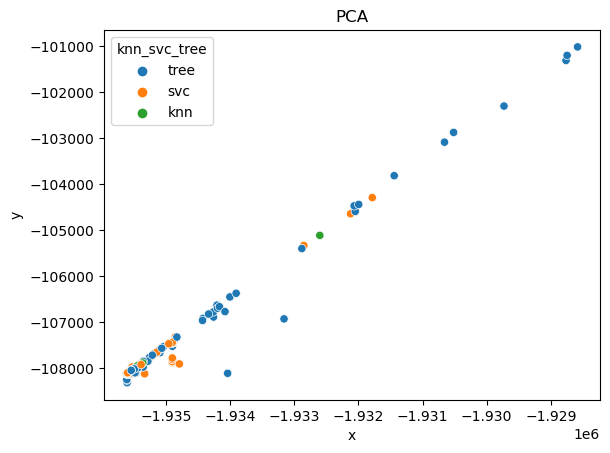

In [87]:
visualizer(two_dimention_dataframe.loc[(two_dimention_dataframe.x <-1.92825*1e6) & (two_dimention_dataframe.y <1*1e6) ], n)

In [31]:
import random
import pandas as pd

class RandomClassifier:
    def __init__(self, name):
        self.random = random.seed(10)
        self.name = name
    def fit(self, X, y):
        self.y = y

    def predict(self, X):
        return pd.DataFrame(
            data=[random.choice(self.y.T.values[0]) for i in range(X.shape[0])],
            columns=[self.name])
        

In [32]:
meta_feature_dataset_X = meta_feature_dataset.drop(['name', meta_feature_dataset.columns.values[-1]], axis=1)
meta_feature_dataset_y = meta_feature_dataset[meta_feature_dataset.columns.values[-1:]]

In [33]:
meta_feature_dataset_X

,columns,objects,nominal,numeric,numeric_min_min,numeric_min_max,numeric_max_min,numeric_max_max,nominal_prob_min_min,nominal_prob_min_max,nominal_prob_max_min,nominal_prob_max_max,nominal_count_min,nominal_count_max,nominal_entropy_min,nominal_entropy_max,depth,leaves
0,3,138,2,1,53.0,53.0,81.0,81.0,0.384058,0.384058,0.652174,0.934783,2,3,-932.977641,-813.403629,7,11
1,5,488,0,5,0.0,2.0,8.0,9.0,0.0,0.004098,0.0,0.0,0,0,0,0,12,142
2,11,1000,0,11,1.0,2.0,2.0,5.0,0.001,0.002,0.0,0.0,0,0,0,0,11,114
3,5,1000,0,5,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0,0,0,0,11,91
4,5,1000,0,5,0.0,1.0,9.0,14.0,0.0,0.001,0.0,0.0,0,0,0,0,9,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,4,662,0,4,2.182963,10425.46,19.704967,223057.33,0.003298,15.748429,0.0,0.0,0,0,0,0,36,637
294,6,66,0,6,-308.9,0.7,1.0,771.7,-4.680303,0.010606,0.0,0.0,0,0,0,0,3,5
295,3,88,0,3,0.37,7.5,1.232,18.0,0.004205,0.085227,0.0,0.0,0,0,0,0,7,18
296,3,222,0,3,1.0,42.0,5.2,95.0,0.004505,0.189189,0.0,0.0,0,0,0,0,11,63


In [34]:
meta_feature_dataset_y

,knn_svc_tree
0,tree
1,svc
2,svc
3,svc
4,svc
...,...
293,tree
294,tree
295,svc
296,tree


In [35]:
X_train, X_test, y_train, y_test = train_test_split(meta_feature_dataset_X, meta_feature_dataset_y)

In [36]:
y_test

,knn_svc_tree
70,svc
76,svc
95,tree
18,tree
218,svc
...,...
204,svc
224,svc
121,tree
296,tree


In [37]:
from sklearn.dummy import DummyClassifier

In [38]:
knn = KNeighborsClassifier(n_neighbors=3)
svc = svm.SVC()
tree_class = tree.DecisionTreeClassifier()
rc = RandomClassifier('knn_svc_tree')
dc = DummyClassifier(strategy='most_frequent')

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)
tree_class.fit(X_train, y_train)
rc.fit(X_train, y_train)
dc.fit(X_train, y_train)

average = 'micro'

knn_precision = precision_score(y_test, knn.predict(X_test), average=average)
svc_precision = precision_score(y_test, svc.predict(X_test), average=average)
tree_class_precision = precision_score(y_test, tree_class.predict(X_test), average=average)
rc_precision = precision_score(y_test, rc.predict(X_test), average=average)
dc_precision = precision_score(y_test, dc.predict(X_test), average=average)

print(knn_precision)
print(svc_precision)
print(tree_class_precision)
print(rc_precision)
print(dc_precision)

0.64
0.41333333333333333
0.6533333333333333
0.41333333333333333
0.36


3--------------------------------------------------------------------------------3

некоторые датасеты имеют только катигориальные признаки 
поэтому мета признак отношение катигориальные к числовым не был реализощщван

Выберите один набор данных. Измените в нём порядок строк, столбцов и категорий. Убедитесь, что мета-признаки от этого не изменились.

In [39]:
# name_to_modify = meta_feature_dataset.head(1)
# name_to_modname_to_modifyify


In [40]:
series_orig = meta_feature_dataset.head(1)
series_orig

,name,columns,objects,nominal,numeric,numeric_min_min,numeric_min_max,numeric_max_min,numeric_max_max,nominal_prob_min_min,nominal_prob_min_max,nominal_prob_max_min,nominal_prob_max_max,nominal_count_min,nominal_count_max,nominal_entropy_min,nominal_entropy_max,depth,leaves,knn_svc_tree
0,1013.arff,3,138,2,1,53.0,53.0,81.0,81.0,0.384058,0.384058,0.652174,0.934783,2,3,-932.977641,-813.403629,7,11,tree


In [41]:
modify_name = meta_feature_dataset.head(1).values[0][0]

In [42]:
modify_name

'1013.arff'

In [43]:
first_arff_orig, meta = arff.loadarff(to_file+modify_name)

In [44]:
first_arff_orig.shape

(138,)

In [45]:
first_arff = first_arff_orig.copy()

In [46]:
columns_for_modification = meta.names()

dataframe_for_modification =  pd.DataFrame(data=first_arff, columns=columns_for_modification)

In [47]:
first_column_name = columns_for_modification.pop(0)
columns_for_modification.append(first_column_name)

types = meta.types()[1:]
types.append(meta.types()[0])

In [48]:
# dataframe_for_modification

In [49]:
dataframe_for_modification = dataframe_for_modification[columns_for_modification]

In [50]:
# dataframe_for_modification

In [51]:
size = dataframe_for_modification.shape[0]
indexes = [i for i in range(1,size)]
indexes.append(0)

In [52]:
dataframe_for_modification=dataframe_for_modification.T[indexes].T

In [53]:
# dataframe_for_modification

In [54]:
# dataframe_for_modification.to_numpy()

In [55]:
dataframe_for_modification.to_numpy().shape[0]

138

In [56]:
modified_series = make_series(modify_name, dataframe_for_modification.to_numpy(), types, columns_for_modification)

In [57]:
series_orig

,name,columns,objects,nominal,numeric,numeric_min_min,numeric_min_max,numeric_max_min,numeric_max_max,nominal_prob_min_min,nominal_prob_min_max,nominal_prob_max_min,nominal_prob_max_max,nominal_count_min,nominal_count_max,nominal_entropy_min,nominal_entropy_max,depth,leaves,knn_svc_tree
0,1013.arff,3,138,2,1,53.0,53.0,81.0,81.0,0.384058,0.384058,0.652174,0.934783,2,3,-932.977641,-813.403629,7,11,tree


In [58]:
modified_series.to_frame().T

,name,columns,objects,nominal,numeric,numeric_min_min,numeric_min_max,numeric_max_min,numeric_max_max,nominal_prob_min_min,nominal_prob_min_max,nominal_prob_max_min,nominal_prob_max_max,nominal_count_min,nominal_count_max,nominal_entropy_min,nominal_entropy_max,depth,leaves,knn_svc_tree
0,1013.arff,3,138,2,1,53.0,53.0,81.0,81.0,0.384058,0.384058,0.652174,0.934783,2,3,-932.977641,-813.403629,3,5,knn


In [59]:
assert series_orig[columns_name].equals(modified_series.to_frame().T[columns_name]) , 'should be equal'

Выберите не менее трёх алгоритмов обучения с учителем и меру оценки алгоритма обучения (валидацию).

В sklearn нет алгоритмов мо, которые работают с катигориальными признаками.
Кажется я поделил на ноль когда считал отношение катигориальных и числовыих признаков.
Видимо надо катигориальные перевести в числовые.

In [60]:
# from sklearn.dummy import DummyClassifier

Постройте мета-набор данных. Для каждого набора данных определите наилучший алгоритм для него.

Визуализируйте мета-набор данных проекцией на двумерном графике. Используйте разные цвета для разных мета-классов.

Протестируйте несколько алгоритмов обучения с учителем (включая наивный алгоритм) на полученном наборе данных.